# Flight scheduling optimization with RL

## Imports

In [5]:
import pandas as pd
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from gymnasium.wrappers import NormalizeObservation, NormalizeReward
from pandas import Timestamp
import warnings

from schedule_optimizer.flight_scheduling import FlightSchedulingEnv
from schedule_optimizer.utils import generate_random_flight_schedule, generate_lambdas

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Simple case : 2 connecting flights

### Generate flight schedule and lambdas

In [6]:
schedule_0 = pd.DataFrame({
    'departure' : [Timestamp('1900-01-01 08:00:00'), Timestamp('1900-01-01 13:30:00')],
    'arrival' : [Timestamp('1900-01-01 10:00:00'), Timestamp('1900-01-01 14:30:00')],
    'way' : [-1, 1],
    'airport' : ['JFK', 'MAD'],
    'departure_minutes' : [480, 910],
    'arrival_minutes' : [600, 970],
})
schedule_0 

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 08:00:00,1900-01-01 10:00:00,-1,JFK,480,600
1,1900-01-01 13:30:00,1900-01-01 14:30:00,1,MAD,910,970


In [7]:
lambdas = generate_lambdas(schedule_0)
lambdas

{'JFKMAD': 1000, 'MADJFK': 1000}

### Custom environment

In [14]:
env = FlightSchedulingEnv(
    flight_schedule=schedule_0, 
    lambdas=lambdas, 
    max_steps=1000,
    revenue_estimation='classic',
    obs='cnx'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)
check_env(env)

### Random Policy

In [15]:
obs = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    obs, reward, done, truncated, _ = env.step(action)
    print(action)
    print("Observation:", obs, "Reward:", reward)

env.close()

4
Observation: [-0.8937984] Reward: 0.0
2
Observation: [-1.87906681] Reward: 27.7777777777776
3
Observation: [-0.66735684] Reward: -27.7777777777776
3
Observation: [0.51597517] Reward: -27.777777777777942
1
Observation: [-0.68273001] Reward: 27.777777777777942
3
Observation: [0.54130273] Reward: -27.777777777777942
4
Observation: [0.52537037] Reward: 0.0
4
Observation: [0.51076681] Reward: 0.0
0
Observation: [1.66678312] Reward: -27.777777777777715
4
Observation: [1.5492912] Reward: 0.0


### RL Policy

In [16]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

In [17]:
for _ in range(10):
    obs, _ = env.reset()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        '''if count < 9:
            action = 1
            count += 1
        else:
            action = 4
            count += 1'''
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    print(total_reward)
env.close()

250.0
250.0
250.0
250.0
250.0
250.0
250.0
250.0
250.0
250.0


### Tensorboard

In [18]:
env = Monitor(env, 'logs/')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="logs/")
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -736     |
| time/              |          |
|    fps             | 1208     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -330        |
| time/                   |             |
|    fps                  | 917         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012954613 |
|    clip_fraction        | 0.272       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        

In [ ]:
%tensorboard --logdir=logs/

## Random schedule

### Generating schedule and lambdas

In [11]:
random_schedule = generate_random_flight_schedule(10)
random_schedule

,departure,arrival,way,airport,departure_minutes,arrival_minutes
0,1900-01-01 08:24:00,1900-01-01 10:21:00,-1,MAD,504,621
1,1900-01-01 09:19:00,1900-01-01 09:52:00,-1,FCO,559,592
2,1900-01-01 11:12:00,1900-01-01 12:51:00,-1,FCO,672,771
3,1900-01-01 12:45:00,1900-01-01 13:18:00,1,FCO,765,798
4,1900-01-01 13:28:00,1900-01-01 15:17:00,1,FCO,808,917
5,1900-01-01 13:43:00,1900-01-01 14:17:00,1,JFK,823,857
6,1900-01-01 16:13:00,1900-01-01 17:26:00,-1,MAD,973,1046
7,1900-01-01 17:30:00,1900-01-01 19:34:00,1,JFK,1050,1174
8,1900-01-01 19:17:00,1900-01-01 20:19:00,1,FCO,1157,1219
9,1900-01-01 21:02:00,1900-01-01 23:05:00,1,MAD,1262,1385


In [12]:
random_lambdas = generate_lambdas(random_schedule)
random_lambdas

{'MADFCO': 1000,
 'FCOMAD': 1000,
 'MADJFK': 1000,
 'JFKMAD': 1000,
 'FCOJFK': 1000,
 'JFKFCO': 1000}

### Custom environment

In [13]:
env = FlightSchedulingEnv(
    flight_schedule=random_schedule,
    lambdas=random_lambdas,
    max_steps=1000,
    revenue_estimation='classic'
)
env = NormalizeObservation(env)
#env = NormalizeReward(env)
check_env(env)

In [14]:
model = PPO("MlpPolicy", env).learn(total_timesteps=100000)

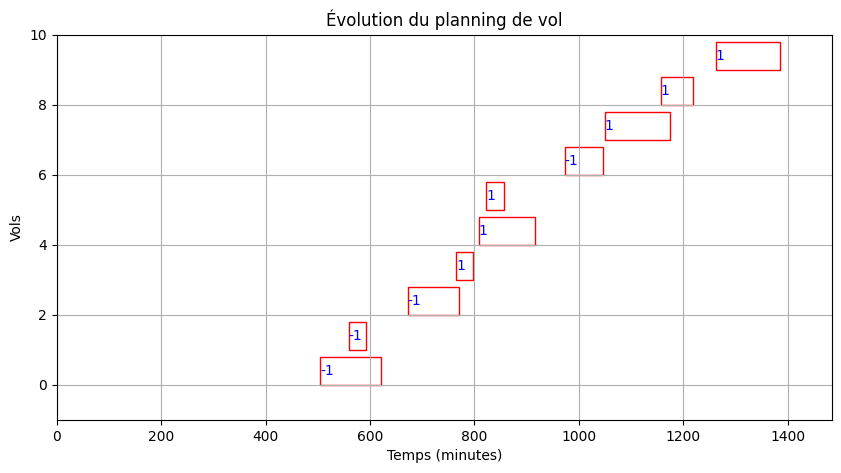

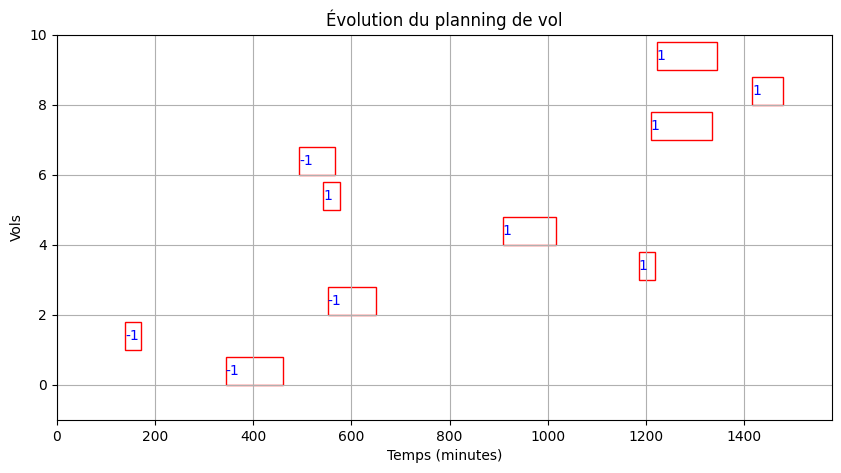

-3838.888888888889


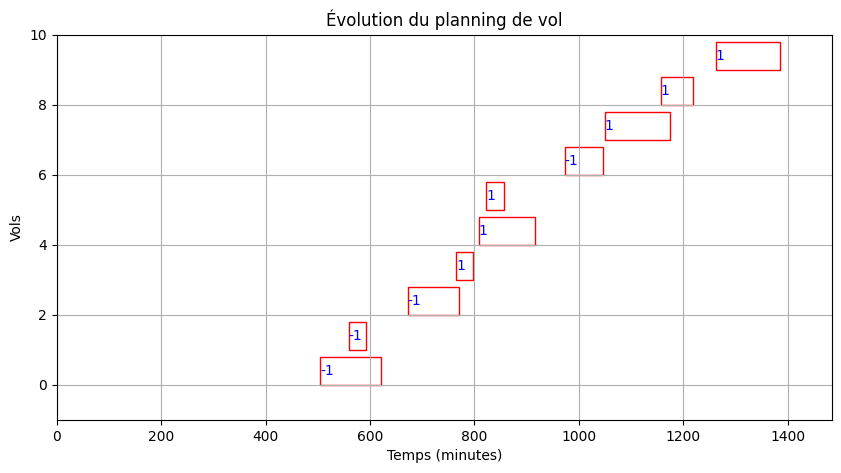

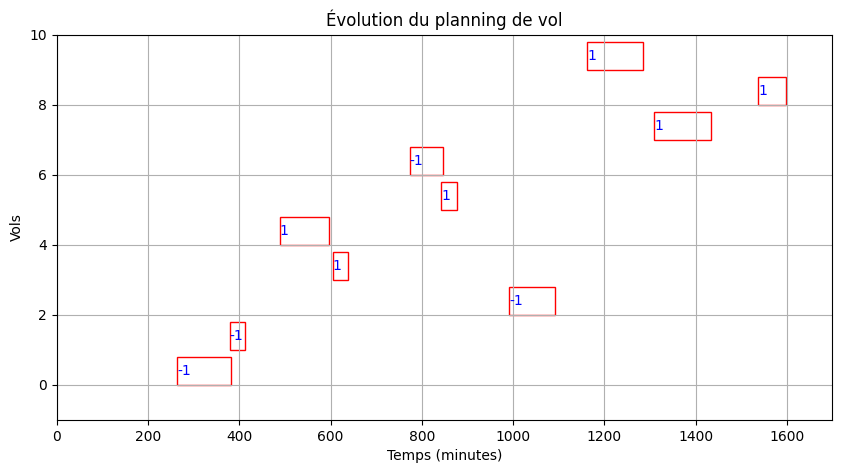

-1594.4444444444453


In [15]:
for _ in range(2):
    obs, _ = env.reset()
    env.renderer()
    total_reward = 0
    done = False
    count = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, _ = env.step(action)
        #print('action : ', action)
        #print('obs : ', obs)
        #print('reward : ', reward)
        total_reward += reward
    env.renderer()
    print(total_reward)
env.close()

### Tensorboard

In [5]:
env = Monitor(env, 'logs/')
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="logs/")
model.learn(total_timesteps=100000)

In [ ]:
%tensorboard --logdir=logs/